In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 10.3 MB/s eta 0:00:00


In [ ]:
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
# 1. Load Data
X_train = pd.read_csv('cleveland_X_train_processed.csv')
X_test = pd.read_csv('cleveland_X_test_processed.csv')
y_train = pd.read_csv('cleveland_y_train_processed.csv').values.ravel()
y_test = pd.read_csv('cleveland_y_test_processed.csv').values.ravel()

In [ ]:
# 2. Define Optuna Objective Function
def objective(trial):
    # Search space for kernel, C, and gamma
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    C = trial.suggest_float('C', 1e-3, 1e2, log=True) # Log-uniform distribution for C
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

    # Initialize SVM with suggested parameters
    # probability=True is not strictly needed for metrics but good practice if you need predict_proba later
    svc = SVC(kernel=kernel, C=C, gamma=gamma)

    # 10-Fold Cross-Validation
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    # n_jobs=-1 uses all CPU cores
    scores = cross_val_score(svc, X_train, y_train, cv=kf, scoring='accuracy', n_jobs=-1)

    return scores.mean()

In [ ]:
# Create and run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2025-12-04 06:38:53,959] A new study created in memory with name: no-name-ee07e2dd-8a5c-42a8-bf09-99c8ef3a5b8c
[I 2025-12-04 06:38:57,571] Trial 0 finished with value: 0.5621212121212121 and parameters: {'kernel': 'poly', 'C': 0.013265125938136882, 'gamma': 'scale'}. Best is trial 0 with value: 0.5621212121212121.
[I 2025-12-04 06:38:57,657] Trial 1 finished with value: 0.5478354978354979 and parameters: {'kernel': 'poly', 'C': 0.0014188560371524988, 'gamma': 'auto'}. Best is trial 0 with value: 0.5621212121212121.
[I 2025-12-04 06:38:57,727] Trial 2 finished with value: 0.5478354978354979 and parameters: {'kernel': 'rbf', 'C': 0.0014612467464395888, 'gamma': 'scale'}. Best is trial 0 with value: 0.5621212121212121.
[I 2025-12-04 06:38:57,796] Trial 3 finished with value: 0.7274891774891775 and parameters: {'kernel': 'rbf', 'C': 23.516124554379388, 'gamma': 'scale'}. Best is trial 3 with value: 0.7274891774891775.
[I 2025-12-04 06:38:57,864] Trial 4 finished with value: 0.8162337662

In [ ]:
best_params = study.best_params
print(f"Best Parameters found: {best_params}")

Best Parameters found: {'kernel': 'linear', 'C': 0.6681333368782871, 'gamma': 'scale'}


In [ ]:
# 3. Retrain Model with Best Parameters
best_svc = SVC(
    kernel=best_params['kernel'],
    C=best_params['C'],
    gamma=best_params['gamma']
)
best_svc.fit(X_train, y_train)

SVC(C=0.6681333368782871, kernel='linear')

In [ ]:
# 4. Evaluate on Training Data
y_train_pred = best_svc.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
train_prec = precision_score(y_train, y_train_pred)
train_rec = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

# 5. Evaluate on Test Data
y_test_pred = best_svc.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred)
test_rec = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

In [ ]:
# 6. Print Results
print("Training Set Metrics:")
print(f"  Accuracy:  {train_acc * 100:.2f}%")
print(f"  Precision: {train_prec * 100:.2f}%")
print(f"  Recall:    {train_rec * 100:.2f}%")
print(f"  F1 Score:  {train_f1 * 100:.2f}%")

print("Test Set Metrics:")
print(f"  Accuracy:  {test_acc * 100:.2f}%")
print(f"  Precision: {test_prec * 100:.2f}%")
print(f"  Recall:    {test_rec * 100:.2f}%")
print(f"  F1 Score:  {test_f1 * 100:.2f}%")

Training Set Metrics:
  Accuracy:  86.79%
  Precision: 88.64%
  Recall:    81.25%
  F1 Score:  84.78%
Test Set Metrics:
  Accuracy:  82.42%
  Precision: 80.00%
  Recall:    83.72%
  F1 Score:  81.82%


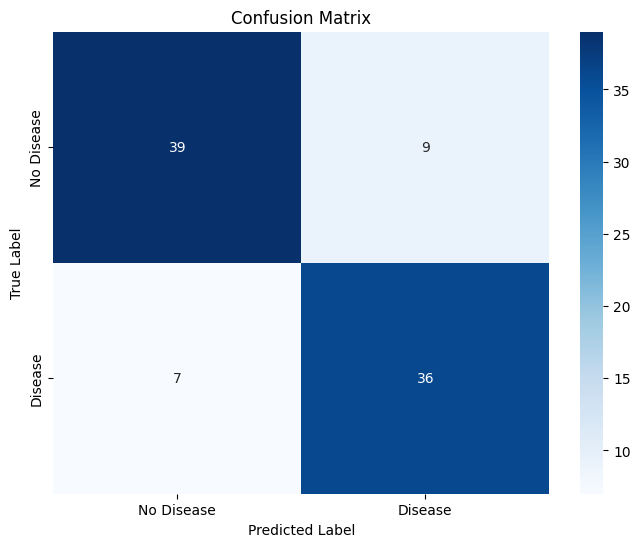

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Tuned Support Vector Classifier Model')
plt.show()